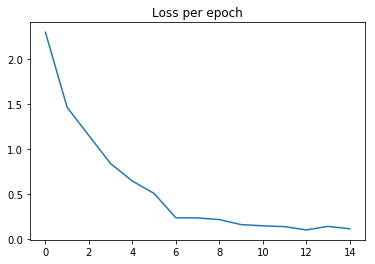

Accuracy =  0.981481481481


In [168]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

digits = load_digits()

learning_rate = 0.001
epochs = 15
mini_batch_size = 32

def one_hot_encoding(i):
    vector = np.zeros((10, 1))
    vector[i] = 1.0
    
    return np.asarray(vector)

x_data = digits.images.reshape(len(digits.images), 8, 8, 1)
y_data = np.asarray([one_hot_encoding(y) for y in digits.target]).reshape(len(digits.target),10)

# Split data set
x, X_test, y, y_test = train_test_split(x_data, y_data, test_size=0.2, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.25, train_size=0.75)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

# Building VGG
X = tf.placeholder(tf.float32, shape = [None, 8, 8, 1])
Y = tf.placeholder(tf.float32, shape = [None, 10])

def weight(shape):
    w = tf.random_normal(shape, mean = 0, stddev = np.sqrt(2.0 / np.prod(shape)))
    return tf.Variable(w)

def bias(shape):
    b = tf.random_uniform(shape, minval = 0, maxval = np.sqrt(2 / shape[0]))
    return tf.Variable(b)

def conv2d(x, w):
    conv_layer = tf.nn.conv2d(x, w, strides = [1, 1, 1, 1], padding = 'SAME')
    return conv_layer
    
def max_pool(x):
    mp_layer = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return mp_layer

conv_1_1_w = weight([3, 3, 1, 8])
conv_1_1_b = bias([8])
conv_1_1 = tf.nn.relu(conv2d(X, conv_1_1_w) + conv_1_1_b)

conv_1_2_w = weight([3, 3, 8, 8])
conv_1_2_b = bias([8])
conv_1_2 = tf.nn.relu(conv2d(conv_1_1, conv_1_2_w) + conv_1_2_b)

conv_1_mp = max_pool(conv_1_2)

conv_2_1_w = weight([3, 3, 8, 16])
conv_2_1_b = bias([16])
conv_2_1 =tf.nn.relu(conv2d(conv_1_mp, conv_2_1_w) + conv_2_1_b)

conv_2_2_w = weight([3, 3, 16, 16])
conv_2_2_b = bias([16])
conv_2_2 = tf.nn.relu(conv2d(conv_2_1, conv_2_2_w) + conv_2_2_b)

conv_2_3_w = weight([3, 3, 16, 16])
conv_2_3_b = bias([16])
conv_2_3 = tf.nn.relu(conv2d(conv_2_2, conv_2_3_w) + conv_2_3_b)

conv_2_4_w = weight([3, 3, 16, 16])
conv_2_4_b = bias([16])
conv_2_4 = tf.nn.relu(conv2d(conv_2_3, conv_2_4_w) + conv_2_4_b)

conv_2_mp = max_pool(conv_2_4)
conv_2_flat = tf.reshape(conv_2_mp, [-1, 2 * 2 * 16])

fc_1_w = weight([2 * 2 * 16, 100])
fc_1_b = bias([100])
fc_1 = tf.nn.relu(tf.matmul(conv_2_flat, fc_1_w) + fc_1_b)

fc_2_w = weight([100, 10])
fc_2_b = bias([10])
fc_2 = tf.nn.relu(tf.matmul(fc_1, fc_2_w) + fc_2_b)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = fc_2))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

list_of_loss = []

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

for i in range(epochs):
    # Shuffle data
    s = np.arange(len(X_train))
    np.random.shuffle(s)
    shuffled_X_train = X_train[s]
    shuffled_y_train = y_train[s]
    for ind in range(0, len(y_train), mini_batch_size):
        sess.run([optimizer, loss], feed_dict={X: shuffled_X_train[ind:ind + mini_batch_size], Y: shuffled_y_train[ind:ind + mini_batch_size]})
    list_of_loss.append(sess.run(loss, feed_dict={X: X_val, Y: y_val}))
    
plt.figure()
plt.title("Loss per epoch")
plt.plot(list_of_loss)
plt.show()

print("Accuracy = ", accuracy_score([np.argmax(y) for y in y_test], [np.argmax(y) for y in sess.run(fc_2, feed_dict={X: X_test, Y: y_test})]))